<a href="https://colab.research.google.com/github/ohse-emily/pytorch/blob/master/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pytorch workflow 

import torch
from torch import nn
import matplotlib.pyplot as plt 

# Check pytorch version
torch.__version__
 

'1.12.1+cu113'

In [ ]:
## 1. Data (preparing & loading)

# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]), 50, 50)

### Splitting data into training and test sets (one of the most important concepts in machine learning in general) 

Let's create a training and test set with out data 

training set = training split


In [ ]:
# Create atrain/test split (보통 8:2 로 하며 split 방식은 여러가지. 여기선 간단하게)
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize out data ? 
This is where the data explorer's motto comes in! 

"Visualize, Visualize, Visualize ! "

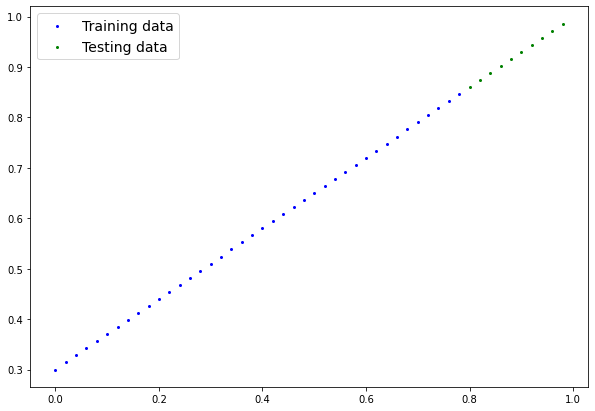

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10,7))

  # Plot trainging data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  # Are there predictions ? 
  if predictions is not None:
    # Plot the predictions if they exist 
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size":14});

plot_predictions();

# blue dots - input
# green dot - ideal output

## Build model

Out first PyTorch model! 🍕


What out model does:
* Start with random values (weight & bias)
* Look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)


Through two main algorithms:
1. Gradient descent 
2. Backpropagation


In [ ]:
# Create linear regression model class

# nn.Module - almost everything in PyTorch inherhits from nn.Module 
# nn - building block layer 

from torch import nn

class LinearRegressionModel(nn.Module): # pytorch model 대부분 nn.Module을 씀 - forward와 세트
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,# <- start with a random weight and try to adjust it to the ideal weight
                                            requires_grad=True, # <- can this parameter be updated via gradient descent?
                                            dtype=torch.float)) # <- pytorch loves datatype torch.float32
    self.bias = nn.Parameter(torch.randn(1, # <- start with a random bias and try to adjust it to the ideal bias
                                         requires_grad=True,
                                         dtype=torch.float))
    
  # Forward method to define the computataion in the model 
  # Any subclass of nn.Module needs to override forward() - this defines for forward computation of the model 
  def forward(self, x:torch.Tensor) -> torch.Tensor: # <- "x" is the input data (training)
    return self.weights * x + self.bias # this is the linear regression formula 


### Pytorch model building essentials 

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - The base class for all neural network modules, if you subclass it, you should overwrite forward() 
* torch.optim - this where the optimizers in PyTorch live, they will help with gradient descent 
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

Now we've created a model, let's see what's inside ! 

In [ ]:
# Create a random seed 
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters 
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [ ]:
weight, bias

(0.7, 0.3)

### Making prediction using 'torch.inference_mode()'

To check our model's predictive power, let's see how well it predicts y_test based on x_test
When we pass data through our model, it's going to run it throught the forward() method. d

In [ ]:
# Make predictions with model 
with torch.inference_mode():
  y_preds = model_0(X_test)

# You can also do somethign similar with torch.no_grad(), however, torch.inference_mode() is preferred.
with torch.no_grad():
  y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [ ]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

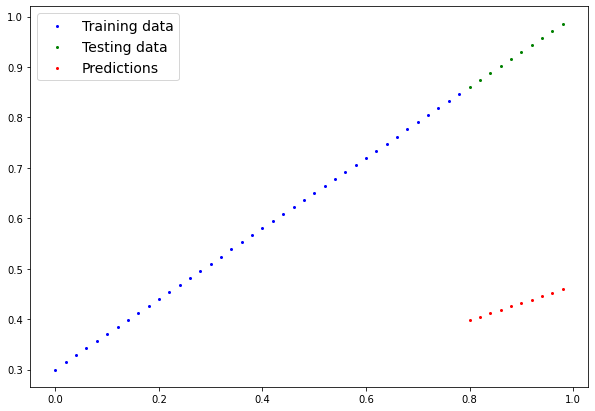

In [ ]:
plot_predictions(predictions=y_preds)

# Train model 

The whole idea of training is for a model to move from some *unknown* parameters (these may be random) to some *known* parameters. 

Or in other words from a poor representation of the data to a better representation of the data. 

One way to measure how poor or how wrong your models predictions are is to use a loss function.

* Note : Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function. 

Things we need to train : 

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better. 

* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters(e.g. weight & bias in our case) to imporve the loss function. 

and specifically for pyTorch, we need :
* A training loop 
* A testing loop 

In [ ]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most important hyperparameter you can set / 클수록 parameters의 변화도 크고 작을수록 작음 


### Building a training & testing loop in PyTorch

A couple of things we need in a training loop :
0. Loop through the data 
1. forward pass (this involves data moving through our model's 'forward()' functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels) 
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [ ]:
list(model_0.eval().parameters())

  # list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [ ]:
torch.manual_seed(42)

# An epoch is one loop through the data 
epochs = 200 # 아무 값이나 될 수 있음 

# Track different values 
epoch_count = []
loss_values = []
test_loss_values = []

# Training 
# 0. Loop through the data 
for epoch in range(epochs):
  # Set the model to training mode 
  model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients 
  
  # 1. Forward pass
  y_pred = model_0(X_train)
  
  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  # print(f"Loss: {loss}")
  
  # 3. Optimizer zero grad
  optimizer.zero_grad()
  
  # 4. Perform backpropagation on the loss with respect to the parameters of the model
  loss.backward()
  
  # 5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the loop so.. we have to zero them above in step 3 for the next iteration of the loop 

  # testing code 함수 분리해서 하는데 연습이라 한번에 함
  model_0.eval() # turns off gradient tracking 
  
  with torch.inference_mode(): # turns off gradient tracking & a couple more things behind the scenes 
    # 1. Do the forward pass
    test_pred = model_0(X_test)
    
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:
      epoch_count.append(epoch)
      loss_values.append(loss)
      test_loss_values.append(test_loss)
      print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
      # Print out model state_dict()
      print(model_0.state_dict())
    


  
  





  



Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788

In [ ]:
import numpy as np
np.array(torch.tensor(loss_values).cpu().numpy())

array([0.31288138, 0.19767132, 0.08908726, 0.05314853, 0.04543797,
       0.04167863, 0.03818933, 0.0347609 , 0.03132383, 0.0278874 ,
       0.02445896, 0.02102021, 0.01758547, 0.01415539, 0.01071659,
       0.00728353, 0.00385178, 0.00893248, 0.00893248, 0.00893248],
      dtype=float32)

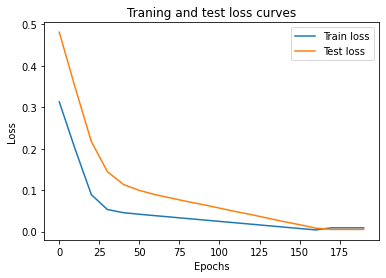

In [ ]:
# Plot the loss curves

plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Traning and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [ ]:
weight, bias

(0.7, 0.3)

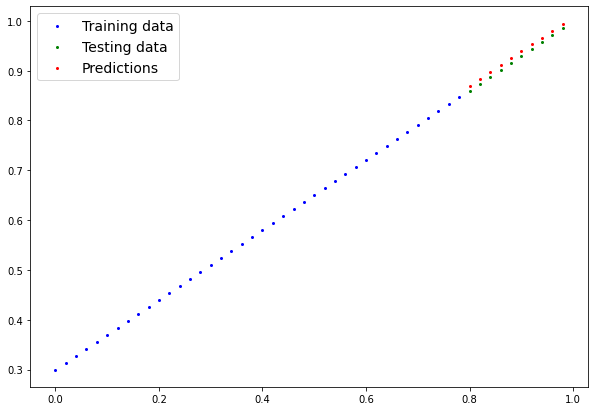

In [ ]:
plot_predictions(predictions=y_preds_new)